In [3]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# BDT training with a simulated sample of signal (S), noise (N) and peaked (P)

## Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp, bdt as lBDT

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split


## Simulation

### Parameters

In [6]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S, "true_pedestal": True},
    "N": {"N": N, "std_N": std_N},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


### Simulation

In [7]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)

dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables +
    ['lower_than_mean_cons', 'larger_than_mean_cons',
     'std_pos', 'std_neg', 'nb_pos', 'nb_neg']
)


Time taken: 1.3836841583251953


In [8]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std',
    'lower_than_mean_cons', 'larger_than_mean_cons',
    'std_pos', 'std_neg',
    'nb_pos', 'nb_neg',
]

columns_to_compute = [
    'max_m_mean', 'min_m_mean', 'pos_max_m_pos_min',
    'mean_m_pedestal',
    'median_m_mean', 'mean_m_std_m_pedestal',
    'std_pos_m_std_neg',
    'nb_pos_m_nb_neg',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'max_std_pos_neg_m_min_std_pos_neg',
    'min_std_pos_neg_red',
    'mean_m_pedestal_red',
    'max_std_pos_neg_red',
    'max_m_mean_red',
    'max_m_pedestal_red',

]

plot_columns = columns_already_computed + columns_to_compute

# colums which wan be used as features for training ======

# For S v P
legal_columns_P = [ 
    'mean_m_pedestal', # 0 for S
    'min_std_pos_neg',

    'lower_than_mean_cons', 'larger_than_mean_cons',
    'std',
    'mean_m_pedestal_red',
    
    'max_std_pos_neg',
    'nb_pos', 'nb_neg', 
    'std_pos_m_std_neg',
    'median_m_mean',
    'mean_m_std_m_pedestal',   
    'nb_pos_m_nb_neg',
    'max_m_pedestal',
    'min_m_pedestal',  
    'max_std_pos_neg_m_min_std_pos_neg',
    
    'mean_m_pedestal_red',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red'
    
    # 'max_m_mean', # /!\ might be mismodeled
    # 'min_m_mean', # /!\ might be mismodeled
    # 'std_pos', 'std_neg', # /!\ use min_std_pos_neg or max_std_pos_neg
]

legal_columns_N = [ 
    'max_m_mean',
    'lower_than_mean_cons',
    'std',

    'larger_than_mean_cons',
    'std_pos', 'std_neg',
    'nb_pos', 'nb_neg', 
    
    'std_pos_m_std_neg',
    'nb_pos_m_nb_neg',
    'min_m_mean', 
    'median_m_mean',
    'max_m_pedestal',
    'min_m_pedestal',
    'mean_m_std_m_pedestal',
    'pos_max_m_pos_min',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'max_m_mean_red'
    
    # 'mean_m_pedestal', # /!\ useless, both should be around 0
    # 'pos_max', 'pos_min', # /!\ might be mismodeled
    # 'pos_max_m_pos_min', # /!\ illegal ?
]

# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)


In [9]:
dict_df = models.get_dict_df(dataframe)
dict_df.keys()

dict_keys(['S', 'N', 'P'])

In [10]:
list_compos = list(dict_df.keys())
list_df = list(dict_df.values())
list_colors, list_labels = fcts.get_list_colors_labels(list_compos)

### Checking plots

Fig saved in /home/anthony/3A_CS/projet_ATLAS/output//images/simulation/BDT_SNP/compare_SNP.png
Fig saved in /home/anthony/3A_CS/projet_ATLAS/output//images/simulation/BDT_SNP/compare_SNP.pdf


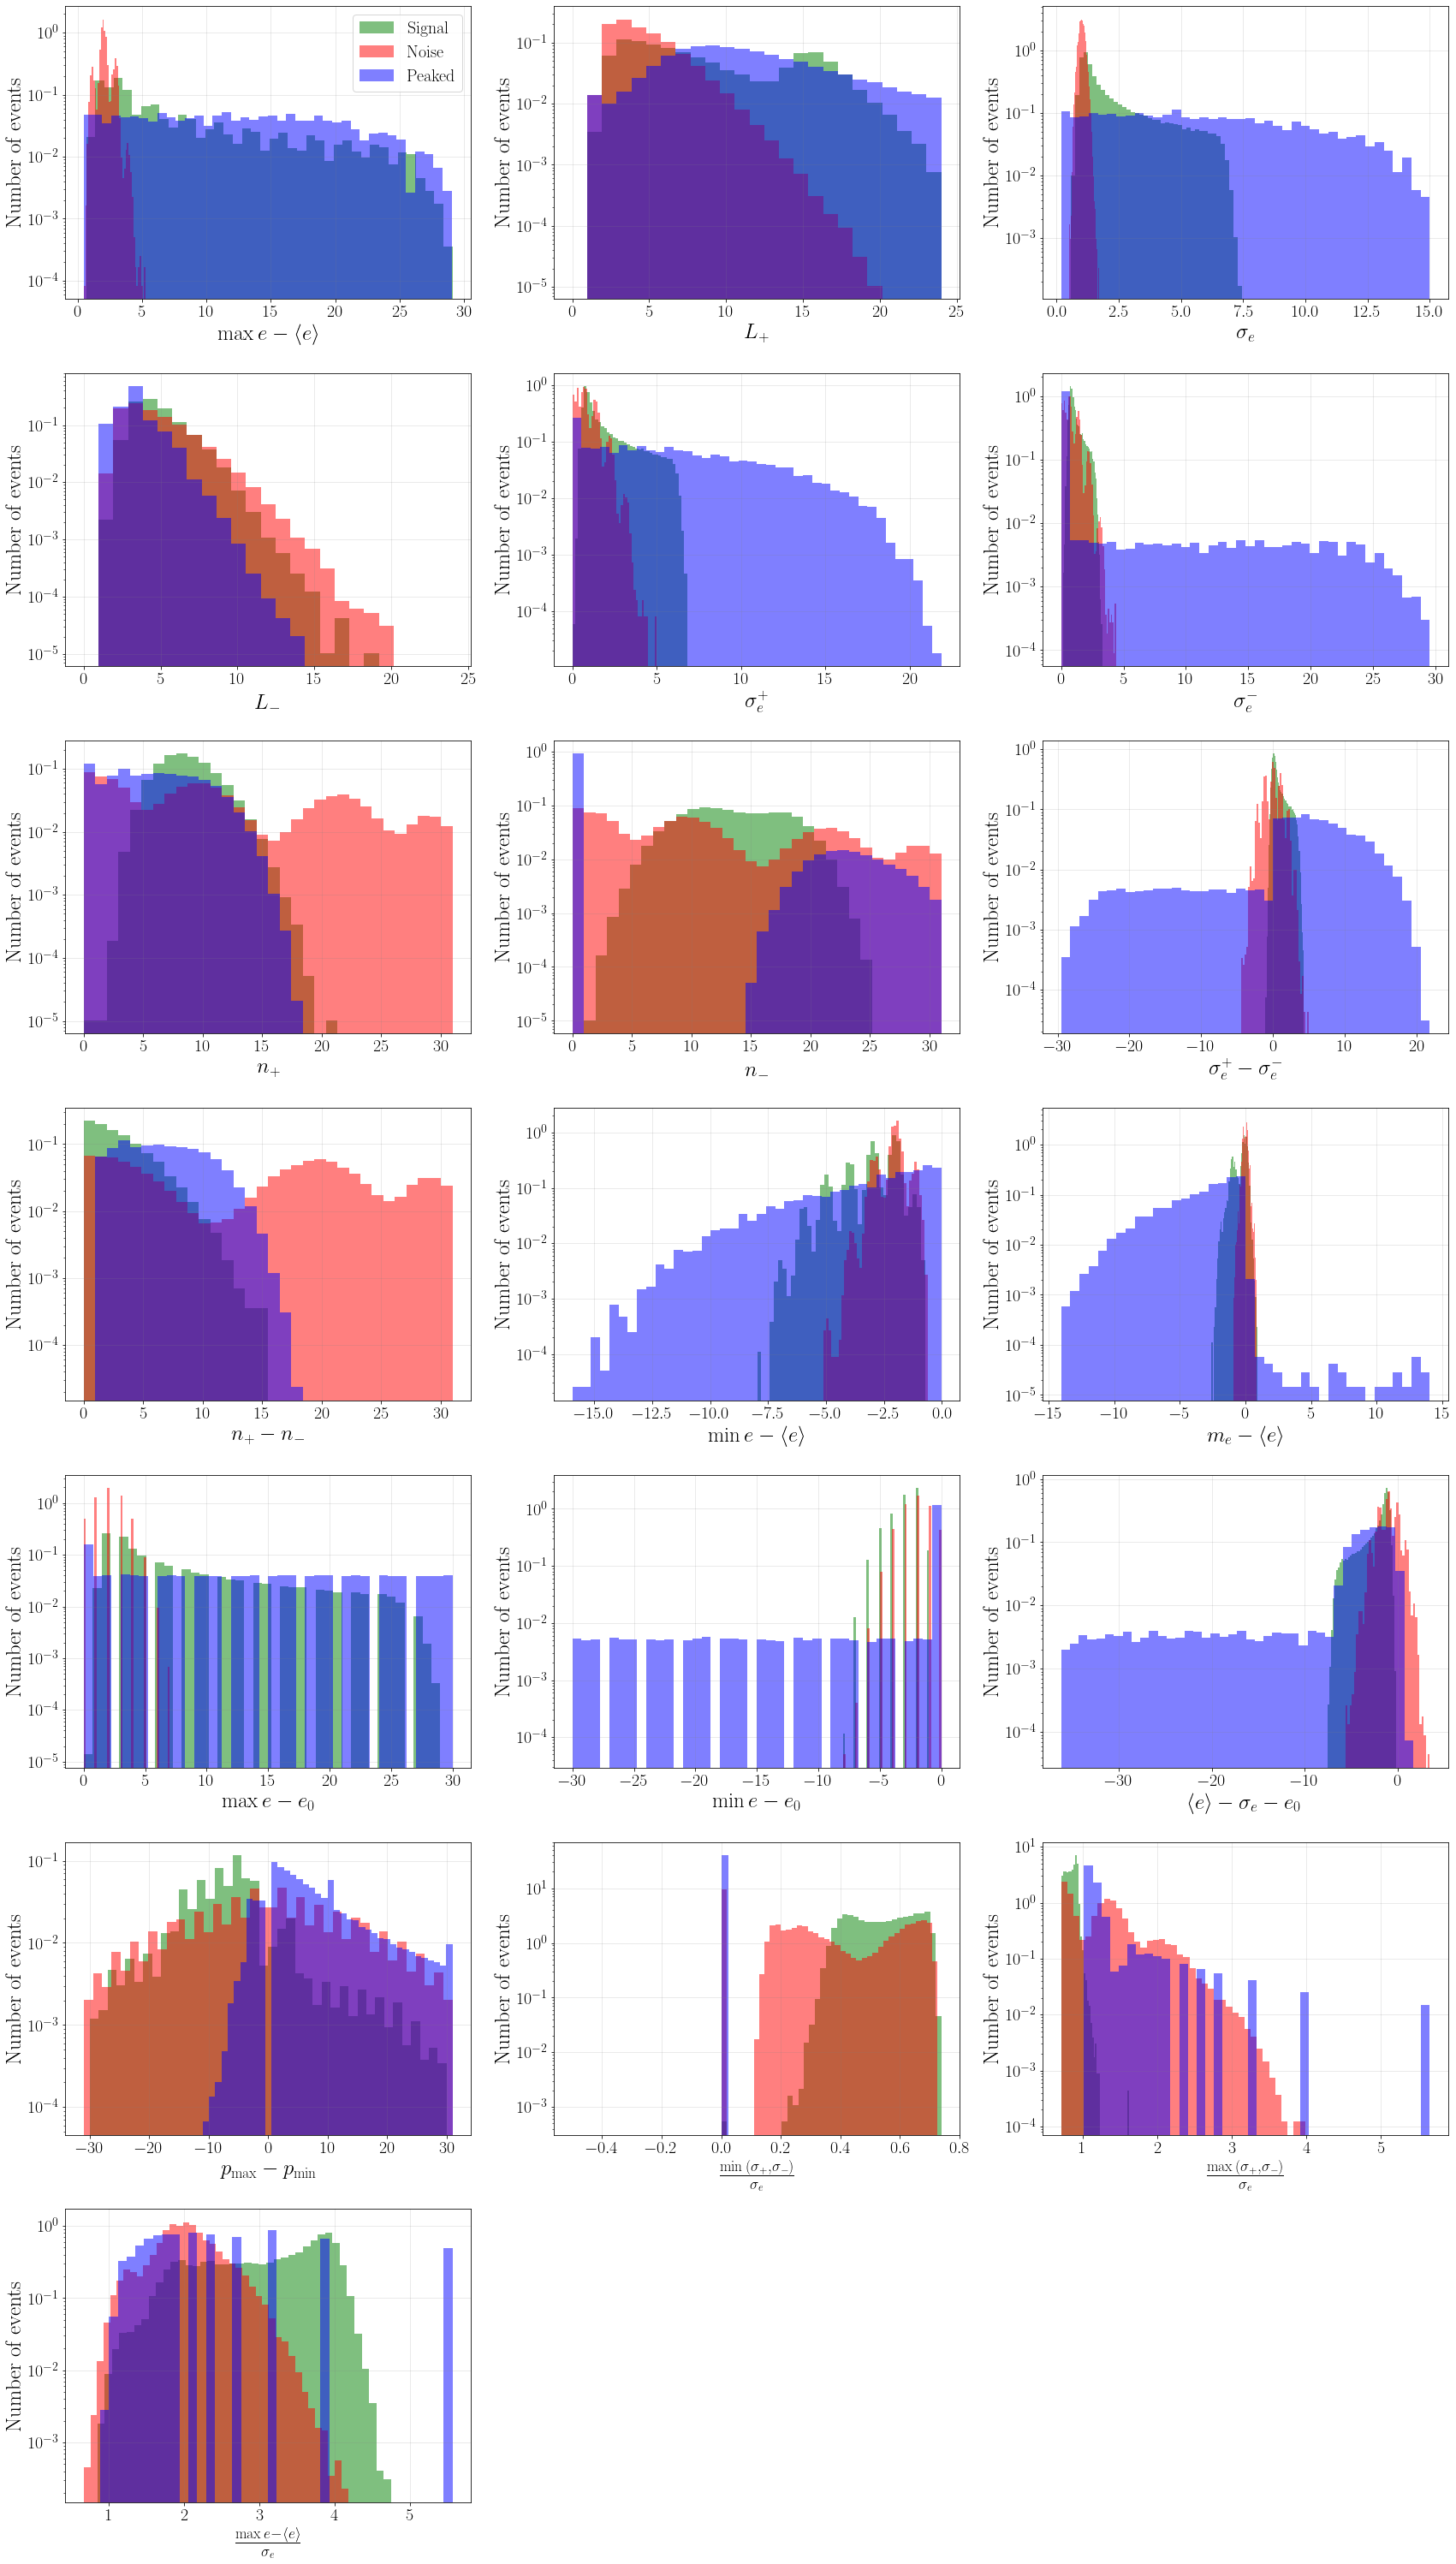

In [11]:
fig, axes = lp.multi_plot_hist(
    list_df, 
    legal_columns_N, column_labels,
    list_colors=list_colors,
    list_labels=list_labels,
    logscale=True,
    nbins={
        'default': 40,
        'lower_than_mean_cons': 25,
        'larger_than_mean_cons': 25,
        'pos_max': 32,
        'pos_min': 32,
        'nb_pos': 32,
        'nb_neg': 32,
        'nb_pos_m_nb_neg': 32,
    },
    range_columns={
        'lower_than_mean_cons': [0, 24],
        'larger_than_mean_cons': [0, 24],
        'pos_max': [0, 31],
        'pos_min': [0, 31],
        'nb_pos': [0, 31],
        'nb_neg': [0, 31],
        'nb_pos_m_nb_neg': [0, 31],
    }
)

lp.save_fig(fig, image_path, "compare_SNP")


We analyse a weird event that is kept by the BDT of S vs P

In [ ]:
# list_samples = [51.0, 48.0,  48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 51.0,
#  48.0, 48.0, 48.0, 1072.0, 48.0, 48.0, 1072.0, 48.0, 48.0, 48.0, 48.0, 1072.0, 48.0, 51.0, 51.0,
#  51.0, 51.0, 48.0]

# df_P_to_remove = pd.DataFrame()
# df_P_to_remove[defs.list_samples_columns] = [list_samples]
# files.compute_voi(
#     df_P_to_remove,
#     variables=defs.computed_variables +
#     ['lower_than_mean_cons', 'larger_than_mean_cons',
#      'std_pos', 'std_neg', 'nb_pos', 'nb_neg']
# )
# df_P_to_remove = data.compute_vals(df_P_to_remove, formula_columns)
# df_P_to_remove["mean_m_pedestal_red"] = df_P_to_remove['mean_m_pedestal'] / df_P_to_remove['std']
# df_P_to_remove["min_std_pos_neg_red"] = df_P_to_remove['min_std_pos_neg'] / df_P_to_remove['std']

# event_P_to_remove = df_P_to_remove.iloc[0]

In [ ]:
# fig, axes = lp.multi_plot_hist(
#     list_df, 
#     legal_columns_P, column_labels,
#     list_colors=list_colors,
#     list_labels=list_labels,
#     logscale=True,
#     nbins={
#         'default': 40,
#         'lower_than_mean_cons': 25,
#         'larger_than_mean_cons': 25,
#         'pos_max': 32,
#         'pos_min': 32,
#         'nb_pos': 32,
#         'nb_neg': 32,
#         'nb_pos_m_nb_neg': 32,
#     },
#     range_columns={
#         'lower_than_mean_cons': [0, 24],
#         'larger_than_mean_cons': [0, 24],
#         'pos_max': [0, 31],
#         'pos_min': [0, 31],
#         'nb_pos': [0, 31],
#         'nb_neg': [0, 31],
#         'nb_pos_m_nb_neg': [0, 31],
#     }
# )

# axes = axes.flat
# for i, column in enumerate(legal_columns_P):
#     axes[i].axvline(x=event_P_to_remove[column], color='k', linestyle='--')


# lp.save_fig(fig, image_path, "compare_SNP_remove_P")


In [ ]:
# fig, axes = plt.subplots(len(list_compos), 1, figsize=(12, 10*len(list_compos)))

# for i, compo in enumerate(list_compos):
#     lp.correlations(dict_df[compo][plot_columns], column_labels, ax=axes[i])

#     axes[i].set_title(var.dict_df_labels[compo])

# plt.tight_layout()

# lp.save_fig(fig, image_path, "correlations")

Somes variables seem interesting to remove to peaked background:
- `pos_min` because it is often close to 0 for peaked background
- `mean - pedestal`, of course !
- `min - pedestal`, which is a bit cheated
- `sigma_neg`, `nb_neg`, ... everything that looks at what is going on for values below the pedestal.

## Training

### Variables to train with

We rank them using the Wasserstein distance.

In [12]:
for compo in list_compos:
    if compo!="S":
        print(var.dict_df_labels[compo], '='*20)
        distances_dict = data.compute_distance_columns(
            dict_df['S'], dict_df[compo], legal_columns_N
        )

Noise ====================
Columns sorted from higher to lower distances
nb_pos_m_nb_neg -----
11.090799999999998
pos_max_m_pos_min -----
7.6813199999999995
max_m_pedestal -----
5.833200000000001
max_m_mean -----
5.8257225
nb_pos -----
5.6618900000000005
nb_neg -----
5.1803099999999995
lower_than_mean_cons -----
4.62515
std -----
1.277467861456444
mean_m_std_m_pedestal -----
1.2699903614564434
std_pos -----
1.1390633957111653
max_m_mean_red -----
1.0284996379078293
min_m_mean -----
0.8453675
min_m_pedestal -----
0.8378899999999999
std_pos_m_std_neg -----
0.8073816110897692
larger_than_mean_cons -----
0.4783400000000003
max_std_pos_neg_red -----
0.42214460417707006
median_m_mean -----
0.33580812499999996
std_neg -----
0.33496028104453435
min_std_pos_neg_red -----
0.18441038739068488
Peaked ====================
Columns sorted from higher to lower distances
pos_max_m_pos_min -----
14.35072
nb_neg -----
11.638020000000001
nb_pos_m_nb_neg -----
10.144580000000001
std_pos_m_std_neg -----
6.5

In [13]:
# train_columns = ['std_neg', 'mean_m_pedestal', 'std']
train_columns = ['pos_max_m_pos_min',  'max_m_pedestal', 'max_m_mean',
    'nb_pos_m_nb_neg', 'lower_than_mean_cons', 'nb_neg', 'nb_pos',
    'std', 'mean_m_std_m_pedestal'
]

list_compos_training = ["S", "N"]

### Prepare dataframes

In [14]:
list_df_train = []
list_df_test = []
for compo in list_compos_training:
    df_compo_train, df_compo_test = \
        train_test_split(dict_df[compo], test_size=0.5,
                        random_state=rng.integers(2**32)
                        )
    list_df_train.append(df_compo_train)
    list_df_test.append(df_compo_test)

df_train = pd.concat(list_df_train)
df_test = pd.concat(list_df_test)

assert len(df_train) == len(df_test)


### Training

In [15]:
hyperparams = {}


In [16]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.05)
bdt = AdaBoostClassifier(dt, algorithm='SAMME', **hyperparams)


In [17]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(AdaBoostClassifier(n_estimators = 100))
sel.fit(df_train[train_columns], df_train['is_sig'])


SelectFromModel(estimator=AdaBoostClassifier(n_estimators=100))

In [18]:
selected_feat= df_train[train_columns].columns[(sel.get_support())]
print(selected_feat)

Index(['max_m_mean', 'nb_pos_m_nb_neg', 'std'], dtype='object')


In [ ]:
bdt.fit(
    df_train[train_columns],
    df_train['is_sig'],
)


### Feature importance

In [ ]:
list_importances = bdt.feature_importances_
index_sort = np.argsort(list_importances)[::-1]
train_columns_sorted = np.array(train_columns)[index_sort]
list_importances_sorted = list_importances[index_sort]

dict_importances = {}

print("COLUMNS SORTED BY IMPORTANCE")
print(f"{'Column':<30} | Importance")
print('-'*50)
for column, importance in zip(train_columns_sorted, list_importances_sorted):
    print(f"{column:<30} | {importance:.2f}")
    dict_importances[column] = importance


## Testing

In [ ]:
_ = lBDT.plot_roc(
    df_test[train_columns],
    df_test["is_sig"],
    bdt
)

lp.save_fig(fig, image_path, "ROC")


In [ ]:
lBDT.compare_train_test(bdt,
                        df_train[train_columns],
                        df_train['cat'],
                        df_test[train_columns],
                        df_test['cat']
                        )

lp.save_fig(fig, image_path, "train_vs_test")

A clear signal peak is visible. It can be investigated.

In [ ]:
lBDT.add_bdt_dataframe(df_train, bdt, train_columns)
lBDT.add_bdt_dataframe(df_test, bdt, train_columns)


In [ ]:
list_BDT_cuts = [-1., 0., 0.6, 0.8, 2.]
amp_S_range = [1, amp_S]


n_intervals = len(list_BDT_cuts) - 1

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(list_BDT_cuts) - 2, -1, -1):
    BDT_cut_low = list_BDT_cuts[i]
    BDT_cut_high = list_BDT_cuts[i+1]

    list_amp_S = df_test.query(
        (f"bdt > {BDT_cut_low} and bdt < {BDT_cut_high}"
         " and is_sig==1")
    )['amp_S']

    ax.hist(
        list_amp_S,
        label=f"{BDT_cut_low} $<$ BDT $<$ {BDT_cut_high}",
        alpha=0.3,
        range=amp_S_range,
        bins=50
    )

ax.set_xlabel('Signal amplitude')
ax.set_ylabel('Number of events')
ax.legend()

ylim = ax.get_ylim()
print(ylim)
ax.set_xlim((1, amp_S))
ax.set_ylim((1, ylim[1]*100))
ax.set_yscale('log')

lp.save_fig(fig, image_path, "BDT_categories")


### Signal purity as a function of the BDT cut

In [ ]:
list_BDT_cuts = np.arange(-1., 1.2, 0.2)
list_S = np.empty_like(list_BDT_cuts)
list_P = np.empty_like(list_BDT_cuts)

for i, BDT_cut in enumerate(list_BDT_cuts):
    dataframe_bdt_cut = df_test.query(f'bdt > {BDT_cut}')
    list_S[i] = len(dataframe_bdt_cut.query('is_sig==True'))
    list_P[i] = len(dataframe_bdt_cut.query('is_peaked==True'))

signal_purity = S / (S + P)
signal_significance = S / np.sqrt(S + P)

fig, axes_ = plt.subplots(2, 2, figsize=(2*8, 2*6))
axes = axes_.flatten()

axes[0].plot(list_BDT_cuts, list_S)
axes[0].set_ylabel('Signal yield $S$')
axes[1].plot(list_BDT_cuts, list_P)
axes[1].set_ylabel('Peak yield $P$')

axes[2].plot(list_BDT_cuts, signal_purity)
axes[2].set_ylabel('Signal purity $\\frac{S}{S+P}$')
axes[3].plot(list_BDT_cuts, signal_significance)
axes[3].set_ylabel('Signal significance $\\frac{S}{\\sqrt{S+P}}$')


for ax in axes:
    ax.set_xlabel('c s.t. BDT output $>$ c')
    lp.set_default_grid(ax)

lp.save_fig(fig, image_path, "yield_variations")


## Save the trained BDT

In [ ]:
from lib.utils import dump_pickle

if optimised:
    pickle_path = op.join(
        var.pickle_path, bdt_name)
else:
    pickle_path = op.join(var.pickle_path, bdt_name + ".pickle")

dump_pickle(
    {
        'bdt': bdt,
        'columns': train_columns
    },
    pickle_path
)


## Look for better hyperparameters

In [ ]:
hyperparams = {
    # 'n_estimators': 1000,
    # 'learning_rate': 0.05
}


In [ ]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1)
bdt = AdaBoostClassifier(dt, algorithm='SAMME', **hyperparams)


In [ ]:
bdt.fit(
    df_train[train_columns],
    df_train['is_sig'],
)


## Testing

In [ ]:
_ = lBDT.plot_roc(
    df_test[train_columns],
    df_test['is_sig'],
    bdt
)

lBDT.compare_train_test(bdt,
                        df_train[train_columns],
                        df_train['is_sig'],
                        df_test[train_columns],
                        df_test['is_sig']
                        )
